# Benchmark para el modelo de embedding 'all-mpnet-base-v2'

## Requisitos

In [1]:
pip install sentence-transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00


In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-mpnet-base-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Prueba pequeña con texto corto utilizando similitud de coseno.

 - objetivo: medir similitud entre gato y felino
 - resultado esperado: valor entre 1 y -1

In [3]:
# Hacemos una pequeña prueba con frases cortas
sentences = [
    "El gato duerme en el sofá",
    "Un felino descansa en el sillón",
    "Hoy hace mucho calor"
]

embeddings = model.encode(sentences, convert_to_tensor=True)

from torch.nn.functional import cosine_similarity
sim = cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0))
print("Similitud gato-felino:", sim.item())

Similitud gato-felino: 0.4942748546600342


### Justificación
- resultado: 0.49427... ≈ 0.5 indica que hay una relación semántica moderada.
- razonamiento: Si bien la palabra 'gato' esta comprendida en el termino 'felino', no las considera equivalentes totales porque están en frases con contextos distintos ('felino en el sillón' es ambiguo, puede ser un tigre).

In [4]:
# Hacemos una pequeña prueba con frases cortas
sentences = [
    "El otro dia me cayó una piedra en el pie",
    "Esa pared está hecha de roca maciza",
    "Hoy hace mucho calor"
]

embeddings = model.encode(sentences, convert_to_tensor=True)

from torch.nn.functional import cosine_similarity
sim = cosine_similarity(embeddings[0].unsqueeze(0), embeddings[1].unsqueeze(0))
print("Similitud roca-piedra:", sim.item())

Similitud roca-piedra: 0.5458943247795105


### Justificación
- resultado: 0.54589... ≈ 0.55 indica que hay una relación semántica moderada.
- razonamiento: - Un valor de 0.54 indica que el modelo detecta una relación moderada entre “piedra” y “roca”, pero no las considera equivalentes totales porque están en frases con contextos distintos (pie vs pared).

## Benchmark Serio

## Usando un dataset estándar (STS-Benchmark)
El STS-Benchmark (Semantic Textual Similarity "stsb") y midiendo los resultados usando pearson y spearman.

In [5]:
# Primer benchmark serio con un dataset ya provisto con la libreria de datasets
from datasets import load_dataset
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Cargar dataset
sts = load_dataset("glue", "stsb", split="validation")

# Calcular similitudes
pred_sims = []
gold_sims = []

for example in sts:
    emb1 = model.encode(example["sentence1"])
    emb2 = model.encode(example["sentence2"])
    sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    pred_sims.append(sim)
    gold_sims.append(example["label"] / 5.0)  # normalizar a [0,1]

# Correlación con etiquetas humanas
print("Pearson:", pearsonr(pred_sims, gold_sims)[0])
print("Spearman:", spearmanr(pred_sims, gold_sims)[0])

README.md: 0.00B [00:00, ?B/s]

stsb/train-00000-of-00001.parquet:   0%|          | 0.00/502k [00:00<?, ?B/s]

stsb/validation-00000-of-00001.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

stsb/test-00000-of-00001.parquet:   0%|          | 0.00/114k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5749 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1379 [00:00<?, ? examples/s]

Pearson: 0.8806252620122922
Spearman: 0.881092768193872


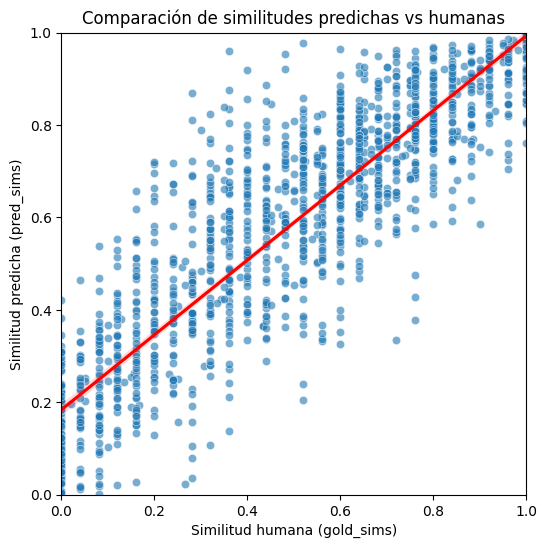

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# Scatter plot de las similitudes
sns.scatterplot(x=gold_sims, y=pred_sims, alpha=0.6)

# Línea de regresión (tendencia)
sns.regplot(x=gold_sims, y=pred_sims, scatter=False, color='red')

# Etiquetas y título
plt.xlabel("Similitud humana (gold_sims)")
plt.ylabel("Similitud predicha (pred_sims)")
plt.title("Comparación de similitudes predichas vs humanas")

# Límites para mejor visualización
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

### Justificación
- Pearson (0.88): mide la correlación lineal entre las similitudes que predice el modelo y las etiquetas humanas. Un valor cercano a 1.0 significa que el modelo ordena las frases casi igual que lo harían los humanos.

- Spearman (0.88): mide la correlación de rangos (como de bien ordena el modelo las frases por similitud, sin importar la escala). También cercano a 1.0, lo que indica que el modelo captura muy bien la relación semántica.

## Usando un dataset confeccionado por nosotros
Utilizamos las mismas metricas pero usando un dataset creado por nosotros que se ajuste más al uso que queremos darle al modelo.

In [16]:
# Primer benchmark serio con un dataset ya provisto con la libreria de datasets
import numpy as np
from scipy.stats import pearsonr, spearmanr
import pandas as pd

# Cargar tu dataset
df = pd.read_csv("/content/drive/MyDrive/Retos/Reto 1 G1/PIA/mi_dataset_benchmark.csv")
display(df.head())

# Convertir a listas
sentences1 = df["sentence1"].tolist()
sentences2 = df["sentence2"].tolist()
labels = df["label"].tolist()

,sentence1,sentence2,label
0,¿Qué pasa si lanzo un hechizo instantáneo en e...,¿Se pueden jugar instantáneos fuera de mi turno?,5
1,¿Cuántas cartas robo al inicio de la partida?,¿Cuál es el tamaño de la mano inicial?,5
2,¿Qué ocurre si una criatura tiene dañar primer...,¿Cómo interactúan las criaturas con dañar prim...,4
3,¿Qué pasa si mi criatura tiene indestructible ...,¿Una criatura indestructible puede morir por d...,4
4,¿Cuántas tierras puedo jugar por turno?,¿Se pueden bajar dos tierras en el mismo turno?,4


In [17]:
# Calcular similitudes
pred_sims = []
gold_sims = []

for s1, s2, label in zip(sentences1, sentences2, labels):
    emb1 = model.encode(s1)
    emb2 = model.encode(s2)
    sim = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
    pred_sims.append(sim)
    gold_sims.append(label / 5.0)  # normalizar si tu escala es 0-5

# Correlación con etiquetas humanas
print("Pearson:", pearsonr(pred_sims, gold_sims)[0])
print("Spearman:", spearmanr(pred_sims, gold_sims)[0])

Pearson: 0.6298686234818742
Spearman: 0.5820146251068042


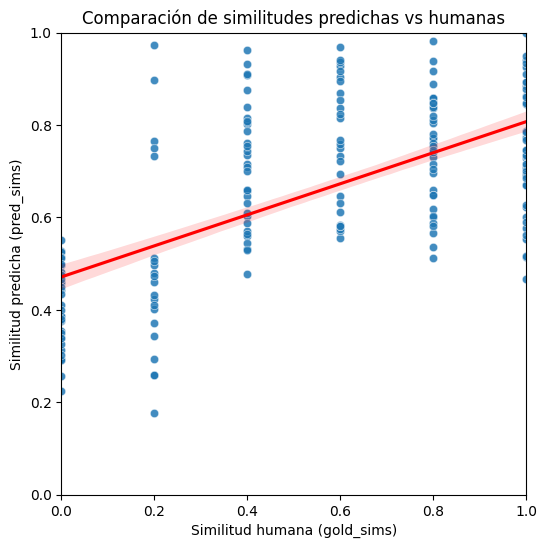

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))

# Scatter plot de las similitudes
sns.scatterplot(x=gold_sims, y=pred_sims, alpha=0.6)

# Línea de regresión (tendencia)
sns.regplot(x=gold_sims, y=pred_sims, scatter=False, color='red')

# Etiquetas y título
plt.xlabel("Similitud humana (gold_sims)")
plt.ylabel("Similitud predicha (pred_sims)")
plt.title("Comparación de similitudes predichas vs humanas")

# Límites para mejor visualización
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

### Justificación
- Pearson (0.88): mide la correlación lineal entre las similitudes que predice el modelo y las etiquetas humanas. Un valor cercano a 1.0 significa que el modelo ordena las frases casi igual que lo harían los humanos.

- Spearman (0.88): mide la correlación de rangos (como de bien ordena el modelo las frases por similitud, sin importar la escala). También cercano a 1.0, lo que indica que el modelo captura muy bien la relación semántica.

##